In [80]:
data_hosts_path = '/kaggle/input/olympic-data/olympic_hosts.csv'
data_medals_path = '/kaggle/input/olympic-data/olympic_medals.csv'
data_results_path = '/kaggle/input/olympic-data/olympic_results.csv'
data_athletes_path = '/kaggle/input/olympic-data/olympic_athletes.csv'

In [81]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [82]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Exploration et nettoyage des données") \
    .getOrCreate()

# Charger les données depuis le fichier CSV
df_hosts = spark.read.csv(data_hosts_path, header=True, inferSchema=True)
df_medals = spark.read.csv(data_medals_path, header=True, inferSchema=True)
df_results = spark.read.csv(data_results_path, header=True, inferSchema=True)
df_athletes = spark.read.csv(data_athletes_path, header=True, inferSchema=True)


24/05/30 14:57:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [83]:
# Afficher les premières observations
df_hosts.show(5)
df_hosts.printSchema()


+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|       game_slug|      game_end_date|    game_start_date|     game_location|       game_name|game_season|game_year|
+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|    beijing-2022|2022-02-20 12:00:00|2022-02-04 15:00:00|             China|    Beijing 2022|     Winter|     2022|
|      tokyo-2020|2021-08-08 14:00:00|2021-07-23 11:00:00|             Japan|      Tokyo 2020|     Summer|     2020|
|pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00| Republic of Korea|PyeongChang 2018|     Winter|     2018|
|        rio-2016|2016-08-21 21:00:00|2016-08-05 12:00:00|            Brazil|        Rio 2016|     Summer|     2016|
|      sochi-2014|2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|      Sochi 2014|     Winter|     2014|
+----------------+-------------------+-------------------+------

In [84]:
df_medals.show(5)
df_medals.printSchema()

+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|discipline_title|   slug_game|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|
+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania CONSTANTINI|       Italy|          IT|                  ITA|
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|        Amos MOSANER|       Italy|          IT|                  ITA|
|         Curling|beijing

In [85]:
df_results.show(5)
df_results.printSchema()

+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|discipline_title|  event_title|   slug_game|participant_type|medal_type|            athletes|rank_equal|rank_position| country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|value_unit|value_type|
+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|[('Stefania CONST...|     False|            1|        Italy|          IT|                  ITA|       NULL|             NULL|      NULL|      NULL|
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    SILVER|[('Kristin SKASLI...|     False|           

In [86]:
df_athletes.show(5)
df_athletes.printSchema()

+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|         athlete_url|   athlete_full_name|games_participations|      first_game|athlete_year_birth|athlete_medals| bio|
+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|https://olympics....|Cooper WOODS-TOPA...|                   1|    Beijing 2022|              2000|          NULL|NULL|
|https://olympics....|      Felix ELOFSSON|                   2|PyeongChang 2018|              1995|          NULL|NULL|
|https://olympics....|       Dylan WALCZYK|                   1|    Beijing 2022|              1993|          NULL|NULL|
|https://olympics....|       Olli PENTTALA|                   1|    Beijing 2022|              1995|          NULL|NULL|
|https://olympics....|    Dmitriy REIKHERD|                   1|    Beijing 2022|              1989|          NULL|NULL|
+--------------------+----------

In [87]:
from pyspark.sql.functions import col, concat_ws, lit, expr

# Effectuer la jointure des DataFrames
data = df_medals.join(df_hosts, df_medals.slug_game == df_hosts.game_slug, how='left')

# Transformer les noms des athlètes en utilisant la capitalisation des mots
data = data.withColumn("athlete_full_name", expr("initcap(athlete_full_name)"))

# Supprimer les colonnes de jointure
data = data.drop("slug_game", "game_slug")

# Supprimer les colonnes non utilisées
data = data.drop("game_end_date", "game_start_date")

# Afficher la forme du DataFrame
data_count = data.count()
data_columns = len(data.columns)

print(f"Le DataFrame final contient {data_count} lignes et {data_columns} colonnes")


Le DataFrame final contient 21697 lignes et 15 colonnes


In [88]:
data.show(5)


+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|   

In [89]:
# Dictionnaires pour les remplacements
country_dict = {
    'German Democratic Republic (Germany)': 'Germany',
    'Federal Republic of Germany': 'Germany',
    "Democratic People's Republic of Korea": 'North Korea',
    "Republic of Korea": "South Korea",
    "People's Republic of China": 'China',
    "Islamic Republic of Iran": 'Iran',
    "United States of America": 'USA'
}


In [90]:
discipline_map = {
    "Gymnastics Artistic": "Artistic Gymnastics",
    "Gymnastics Rhythmic": "Rhythmic Gymnastics",
    "Synchronized Swimming": "Artistic Swimming",
    "Equestrian Dressage": "Equestrian",
    "Equestrian Jumping": "Equestrian",
    "Equestrian Eventing": "Equestrian",
    "Trampoline": "Trampoline Gymnastics",
    "Cycling BMX": "Cycling BMX Racing",
    "Short Track Speed Skating": "Short Track"
}

In [91]:
from pyspark.sql.functions import  when
# Fonction pour appliquer les remplacements
def replace_column_values(df, column, replacement_dict):
    for original, replacement in replacement_dict.items():
        df = df.withColumn(column, when(col(column) == original, replacement).otherwise(col(column)))
    return df

# Appliquer les remplacements pour les noms des pays
data = replace_column_values(data, "country_name", country_dict)

# Appliquer les remplacements pour les noms des disciplines
data = replace_column_values(data, "discipline_title", discipline_map)

# Afficher les 5 premières lignes du DataFrame final
data.show(5)

+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|   

The dataset contains two different rows for both winners in a team competition that consists of two persons, but it is one medal in total. For example, you can check the Tennis Doubles Men competition. Let's split the dataset into parts, group those team competitions, and join data again.

In [92]:
# Filtrer les données pour les athlètes
data_athlete = data.filter(col('participant_type') == 'Athlete')

# Obtenir le nombre de lignes et de colonnes
num_rows = data_athlete.count()
num_cols = len(data_athlete.columns)

print(f"Le DataFrame des athlètes contient {num_rows} lignes et {num_cols} colonnes")
# Afficher les 5 premières lignes du DataFrame des athlètes
data_athlete.show(5)


Le DataFrame des athlètes contient 15113 lignes et 15 colonnes
+----------------+--------------------+------------+----------+----------------+-----------------+--------------------+-----------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|         event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+--------------------+------------+----------+----------------+-----------------+--------------------+-----------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|Freestyle Skiing|        Men's Moguls|         Men|    SILVER|         Athlete|             NULL|https://olympics....| Mikael Kingsbury|      Canada|          CA|                  CAN|        China|Beijing 2022|     Winter|     202

In [93]:
# Filtrer les données pour les équipes
data_team = data.filter(col('participant_type') == 'GameTeam')

# Obtenir le nombre de lignes et de colonnes
num_rows = data_team.count()
num_cols = len(data_team.columns)

print(f"Le DataFrame des équipes contient {num_rows} lignes et {num_cols} colonnes")

# Afficher les 5 premières lignes du DataFrame des équipes
data_team.show(5)


Le DataFrame des équipes contient 6584 lignes et 15 colonnes
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curli

In [94]:
# Filtrer les données où `athlete_full_name` est null
data_team_a = data_team.filter(col('athlete_full_name').isNull())

# Obtenir le nombre de lignes et de colonnes
num_rows_team_a = data_team_a.count()
num_cols_team_a = len(data_team_a.columns)

print(f"Le DataFrame des équipes avec `athlete_full_name` null contient {num_rows_team_a} lignes et {num_cols_team_a} colonnes")

# Afficher les 5 premières lignes du DataFrame filtré
data_team_a.show(5)


Le DataFrame des équipes avec `athlete_full_name` null contient 3624 lignes et 15 colonnes
+----------------+-----------+------------+----------+----------------+-----------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|event_title|event_gender|medal_type|participant_type|participant_title|athlete_url|athlete_full_name| country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-----------+------------+----------+----------------+-----------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|      Women|       Women|      GOLD|        GameTeam|    Great Britain|       NULL|             NULL|Great Britain|          GB|                  GBR|        China|Beijing 2022|     Winter|     2022|
|         Curling|      Women|       

In [95]:
from pyspark.sql.functions import col, expr, when, isnull, collect_set, first, udf
from pyspark.sql.types import ArrayType, StringType

data_team_b = data_team.filter(col('athlete_full_name').isNotNull())

# Colonnes pour le groupement
group_columns = ['discipline_title', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'participant_title',
                 'country_name', 'country_3_letter_code', 'game_location', 'game_season', 'game_name', 'game_year']

# Colonnes pour l'agrégation
agg_columns = ['country_code', 'athlete_full_name']

# Grouper par les colonnes spécifiées et agréger
data_team_b_grouped = data_team_b.groupBy(group_columns).agg(
    first('country_code').alias('country_code'),
    collect_set('athlete_full_name').alias('athlete_full_names')
)

# Convertir `collect_set` de `athlete_full_name` en liste
@udf(ArrayType(StringType()))
def to_list(x):
    return list(x)

data_team_b_grouped = data_team_b_grouped.withColumn('athlete_full_names', to_list(col('athlete_full_names')))

# Afficher le nombre de lignes et de colonnes
num_rows_team_b = data_team_b_grouped.count()
num_cols_team_b = len(data_team_b_grouped.columns)

print(f"Le DataFrame des équipes agrégé contient {num_rows_team_b} lignes et {num_cols_team_b} colonnes")

# Afficher les 5 premières lignes du DataFrame agrégé
data_team_b_grouped.show(5)


Le DataFrame des équipes agrégé contient 1480 lignes et 14 colonnes


+-------------------+--------------------+------------+----------+----------------+--------------------+------------+---------------------+-------------+-----------+-----------+---------+------------+--------------------+
|   discipline_title|         event_title|event_gender|medal_type|participant_type|   participant_title|country_name|country_3_letter_code|game_location|game_season|  game_name|game_year|country_code|  athlete_full_names|
+-------------------+--------------------+------------+----------+----------------+--------------------+------------+---------------------+-------------+-----------+-----------+---------+------------+--------------------+
|            Archery|          Mixed Team|       Mixed|    BRONZE|        GameTeam|              Mexico|      Mexico|                  MEX|        Japan|     Summer| Tokyo 2020|     2020|          MX|[Luis Alvarez, Al...|
|            Archery|          Mixed Team|       Mixed|      GOLD|        GameTeam|   Republic of Korea| South K

In [96]:
# Concaténer les DataFrames
data_medal = data_team_a.union(data_team_b).union(data_athlete)
# Obtenir le nombre total de lignes
total_rows = data_medal.count()
print("Le DataFrame concaténé contient {} lignes".format(total_rows))


Le DataFrame concaténé contient 21697 lignes


In [97]:
from pyspark.sql.functions import when

data_medal = data_medal.withColumn("discipline_title", 
                                   when(data_medal["event_title"] == "Baseball", "Baseball")
                                   .when(data_medal["event_title"] == "Softball", "Softball")
                                   .otherwise(data_medal["discipline_title"]))

data_medal = data_medal.withColumn("event_title", 
                                   when(data_medal["event_title"] == "Baseball", "baseball men")
                                   .when(data_medal["event_title"] == "Softball", "softball women")
                                   .otherwise(data_medal["event_title"]))
data_medal = data_medal.withColumn("discipline_title", 
                                   when(data_medal["event_title"] == "rugby-7 men", "Rugby Sevens")
                                   .when(data_medal["event_title"] == "rugby-7 women", "Rugby Sevens")
                                   .otherwise(data_medal["discipline_title"]))

data_medal = data_medal.withColumn("event_title", 
                                   when(data_medal["event_title"] == "rugby-7 men", "Men")
                                   .when(data_medal["event_title"] == "rugby-7 women", "Women")
                                   .otherwise(data_medal["event_title"]))


In [98]:
from pyspark.sql.functions import count, when
from pyspark.sql import DataFrame

def get_disciplines_game(df: DataFrame, season: str):
    # Filtrer les données pour la saison spécifiée
    df_season = df.filter(df['game_season'] == season)

    # Compter le nombre de participants par discipline et année
    df_disciplines_year = df_season.groupby('discipline_title', 'game_year') \
        .agg(count('participant_type').alias('participant_count'))

    # Pivoter les données pour avoir les années comme colonnes et les disciplines comme lignes
    df_heatmap = df_disciplines_year.groupby('discipline_title') \
        .pivot('game_year') \
        .agg(when(count('participant_count') > 0, 1).otherwise(0)) \
        .fillna(0)

    # Renommer les colonnes
    df_heatmap = df_heatmap.toPandas()
    df_heatmap.columns = [str(col) for col in df_heatmap.columns]

    # Remplacer les espaces dans l'index par des sauts de ligne
    df_heatmap.index = [str(idx).replace(' ', '\n', 1) for idx in df_heatmap.index]

    return df_heatmap



In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disciplines(data, title, size=(16, 16)):
    '''
    Return plot
    '''
    plt.figure(figsize=size)
    ax = sns.heatmap(data.to_pandas(), annot=False, cbar=False, 
                     linewidths=0.8, linecolor='black', 
                     square=True, cmap='Spectral')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title('{} Games'.format(title), size=22)
    plt.tight_layout()
    plt.show()


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disciplines(data, title, size=(16, 16)):
    '''
    Return plot
    '''
    # Créer un mapping des disciplines sportives à des valeurs numériques
    discipline_mapping = {discipline: i for i, discipline in enumerate(data.index)}
    
    # Convertir les noms des disciplines sportives en valeurs numériques
    data_numeric = data.rename(index=discipline_mapping)
    
    plt.figure(figsize=size)
    ax = sns.heatmap(data_numeric, annot=False, cbar=False, 
                     linewidths=0.8, linecolor='black', 
                     square=True, cmap='Spectral')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title('{} Games'.format(title), size=22)
    plt.tight_layout()
    plt.show()


# Obtention des données pour la saison spécifiée
season = 'Summer'
size = (20, 38)

# Obtention des données pour la saison spécifiée
disciplines = get_disciplines_game(data_medal, season)

# Traçage des disciplines
plot_disciplines(disciplines, title=season, size=size)



24/05/30 14:59:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


ValueError: could not convert string to float: 'Tennis'

<Figure size 2000x3800 with 0 Axes>

In [101]:
from pyspark.sql.functions import col

# Filtrer les données pour ne conserver que les jeux d'été et supprimer la colonne 'game_season'
data_summer = data_medal.filter(col('game_season') == 'Summer').drop('game_season')



In [102]:
data_summer.show()

+-----------------+--------------------+------------+----------+----------------+-----------------+-----------+-----------------+------------+------------+---------------------+-------------+----------+---------+
| discipline_title|         event_title|event_gender|medal_type|participant_type|participant_title|athlete_url|athlete_full_name|country_name|country_code|country_3_letter_code|game_location| game_name|game_year|
+-----------------+--------------------+------------+----------+----------------+-----------------+-----------+-----------------+------------+------------+---------------------+-------------+----------+---------+
|     Canoe Sprint|Men's Kayak Four ...|         Men|      GOLD|        GameTeam|          Germany|       NULL|             NULL|     Germany|          DE|                  GER|        Japan|Tokyo 2020|     2020|
|     Canoe Sprint|Men's Kayak Four ...|         Men|    SILVER|        GameTeam|            Spain|       NULL|             NULL|       Spain|      

In [103]:
data_medal.show()

# Assuming 'data_medal' is your PySpark DataFrame
data_medal.write.csv('/kaggle/working/data_medal', header=True)


+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|        event_title|event_gender|medal_type|participant_type|   participant_title|athlete_url|athlete_full_name| country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|              Women|       Women|      GOLD|        GameTeam|       Great Britain|       NULL|             NULL|Great Britain|          GB|                  GBR|        China|Beijing 2022|     Winter|     2022|
|         Curling|              Women|       Women|    SILVER|        GameTeam|     

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/kaggle/working/data_medal already exists. Set mode as "overwrite" to overwrite the existing path.

In [104]:
def sort_games_name(game_name_list):
    '''
    Input: ['Sydney 2000', 'Atlanta 1996', 'Beijing 2008', 'Athens 2004']
    Output: ['Atlanta 1996', 'Sydney 2000', 'Athens 2004', 'Beijing 2008'
    '''
    game_name_tuple_split = [(i[:-5], i[-4:]) for i in game_name_list]
    game_name_tuple_sorted = sorted(game_name_tuple_split, key=lambda x: x[1])
    game_name_list_sorted = [' '.join(i) for i in game_name_tuple_sorted]
    return game_name_list_sorted

from pyspark.sql.functions import col

def get_country_medal(data, country):
    data_country = data.filter(data['country_name'] == country)
    data_medal = data_country.groupby(['game_name', 'discipline_title']) \
                             .agg({'participant_type': 'count'}) \
                             .withColumnRenamed('count(participant_type)', 'participant_type') \
                             .toPandas()
    data_medal = data_medal.pivot_table(index='discipline_title', columns='game_name', values='participant_type', fill_value=0)
    sorted_columns = sort_games_name(data_medal.columns)
    data_medal = data_medal.reindex(columns=sorted_columns)
    data_medal['Total'] = data_medal.sum(axis=1)
    data_medal.loc["Total"] = data_medal.sum()
    return data_medal




def plot_country_medal(data, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, annot=True, annot_kws={"fontsize":20},
                     cbar=False, linewidths=.8, fmt='g', cmap='coolwarm')
#     ax.set_title('Team', size=20)
    ax.tick_params(axis='x', which='major', labelsize=5)
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.xaxis.tick_top()
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.tight_layout()
#     plt.savefig('medals.png', dpi=300)
    plt.show()


In [105]:
from pyspark.sql.functions import count

country_medal = data_summer.groupby('country_name') \
                           .agg(count('participant_type').alias('total_number')) \
                           .sort('total_number', ascending=False) \
                           .limit(10)


In [106]:
# Filtrer les données pour l'année 2022
df_2022 = data_medal.filter(data_medal.game_year == 2022)

# Afficher les données filtrées
df_2022.show()

# Assuming 'df_2022' is your PySpark DataFrame
df_2022.write.csv('/kaggle/working/df_2022', header=True)

# Compter le nombre de médailles gagnées par chaque pays en 2022
medals_count = df_2022.groupBy("country_name", "medal_type").count()

# Afficher le tableau des médailles
medals_count.show()

+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|        event_title|event_gender|medal_type|participant_type|   participant_title|athlete_url|athlete_full_name| country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|              Women|       Women|      GOLD|        GameTeam|       Great Britain|       NULL|             NULL|Great Britain|          GB|                  GBR|        China|Beijing 2022|     Winter|     2022|
|         Curling|              Women|       Women|    SILVER|        GameTeam|     

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/kaggle/working/df_2022 already exists. Set mode as "overwrite" to overwrite the existing path.

In [107]:
country_medal.show()


+-------------+------------+
| country_name|total_number|
+-------------+------------+
|          USA|        2732|
|      Germany|        1491|
| Soviet Union|        1055|
|Great Britain|        1008|
|       France|         805|
|        China|         723|
|        Italy|         646|
|    Australia|         608|
|      Hungary|         543|
|       Sweden|         525|
+-------------+------------+



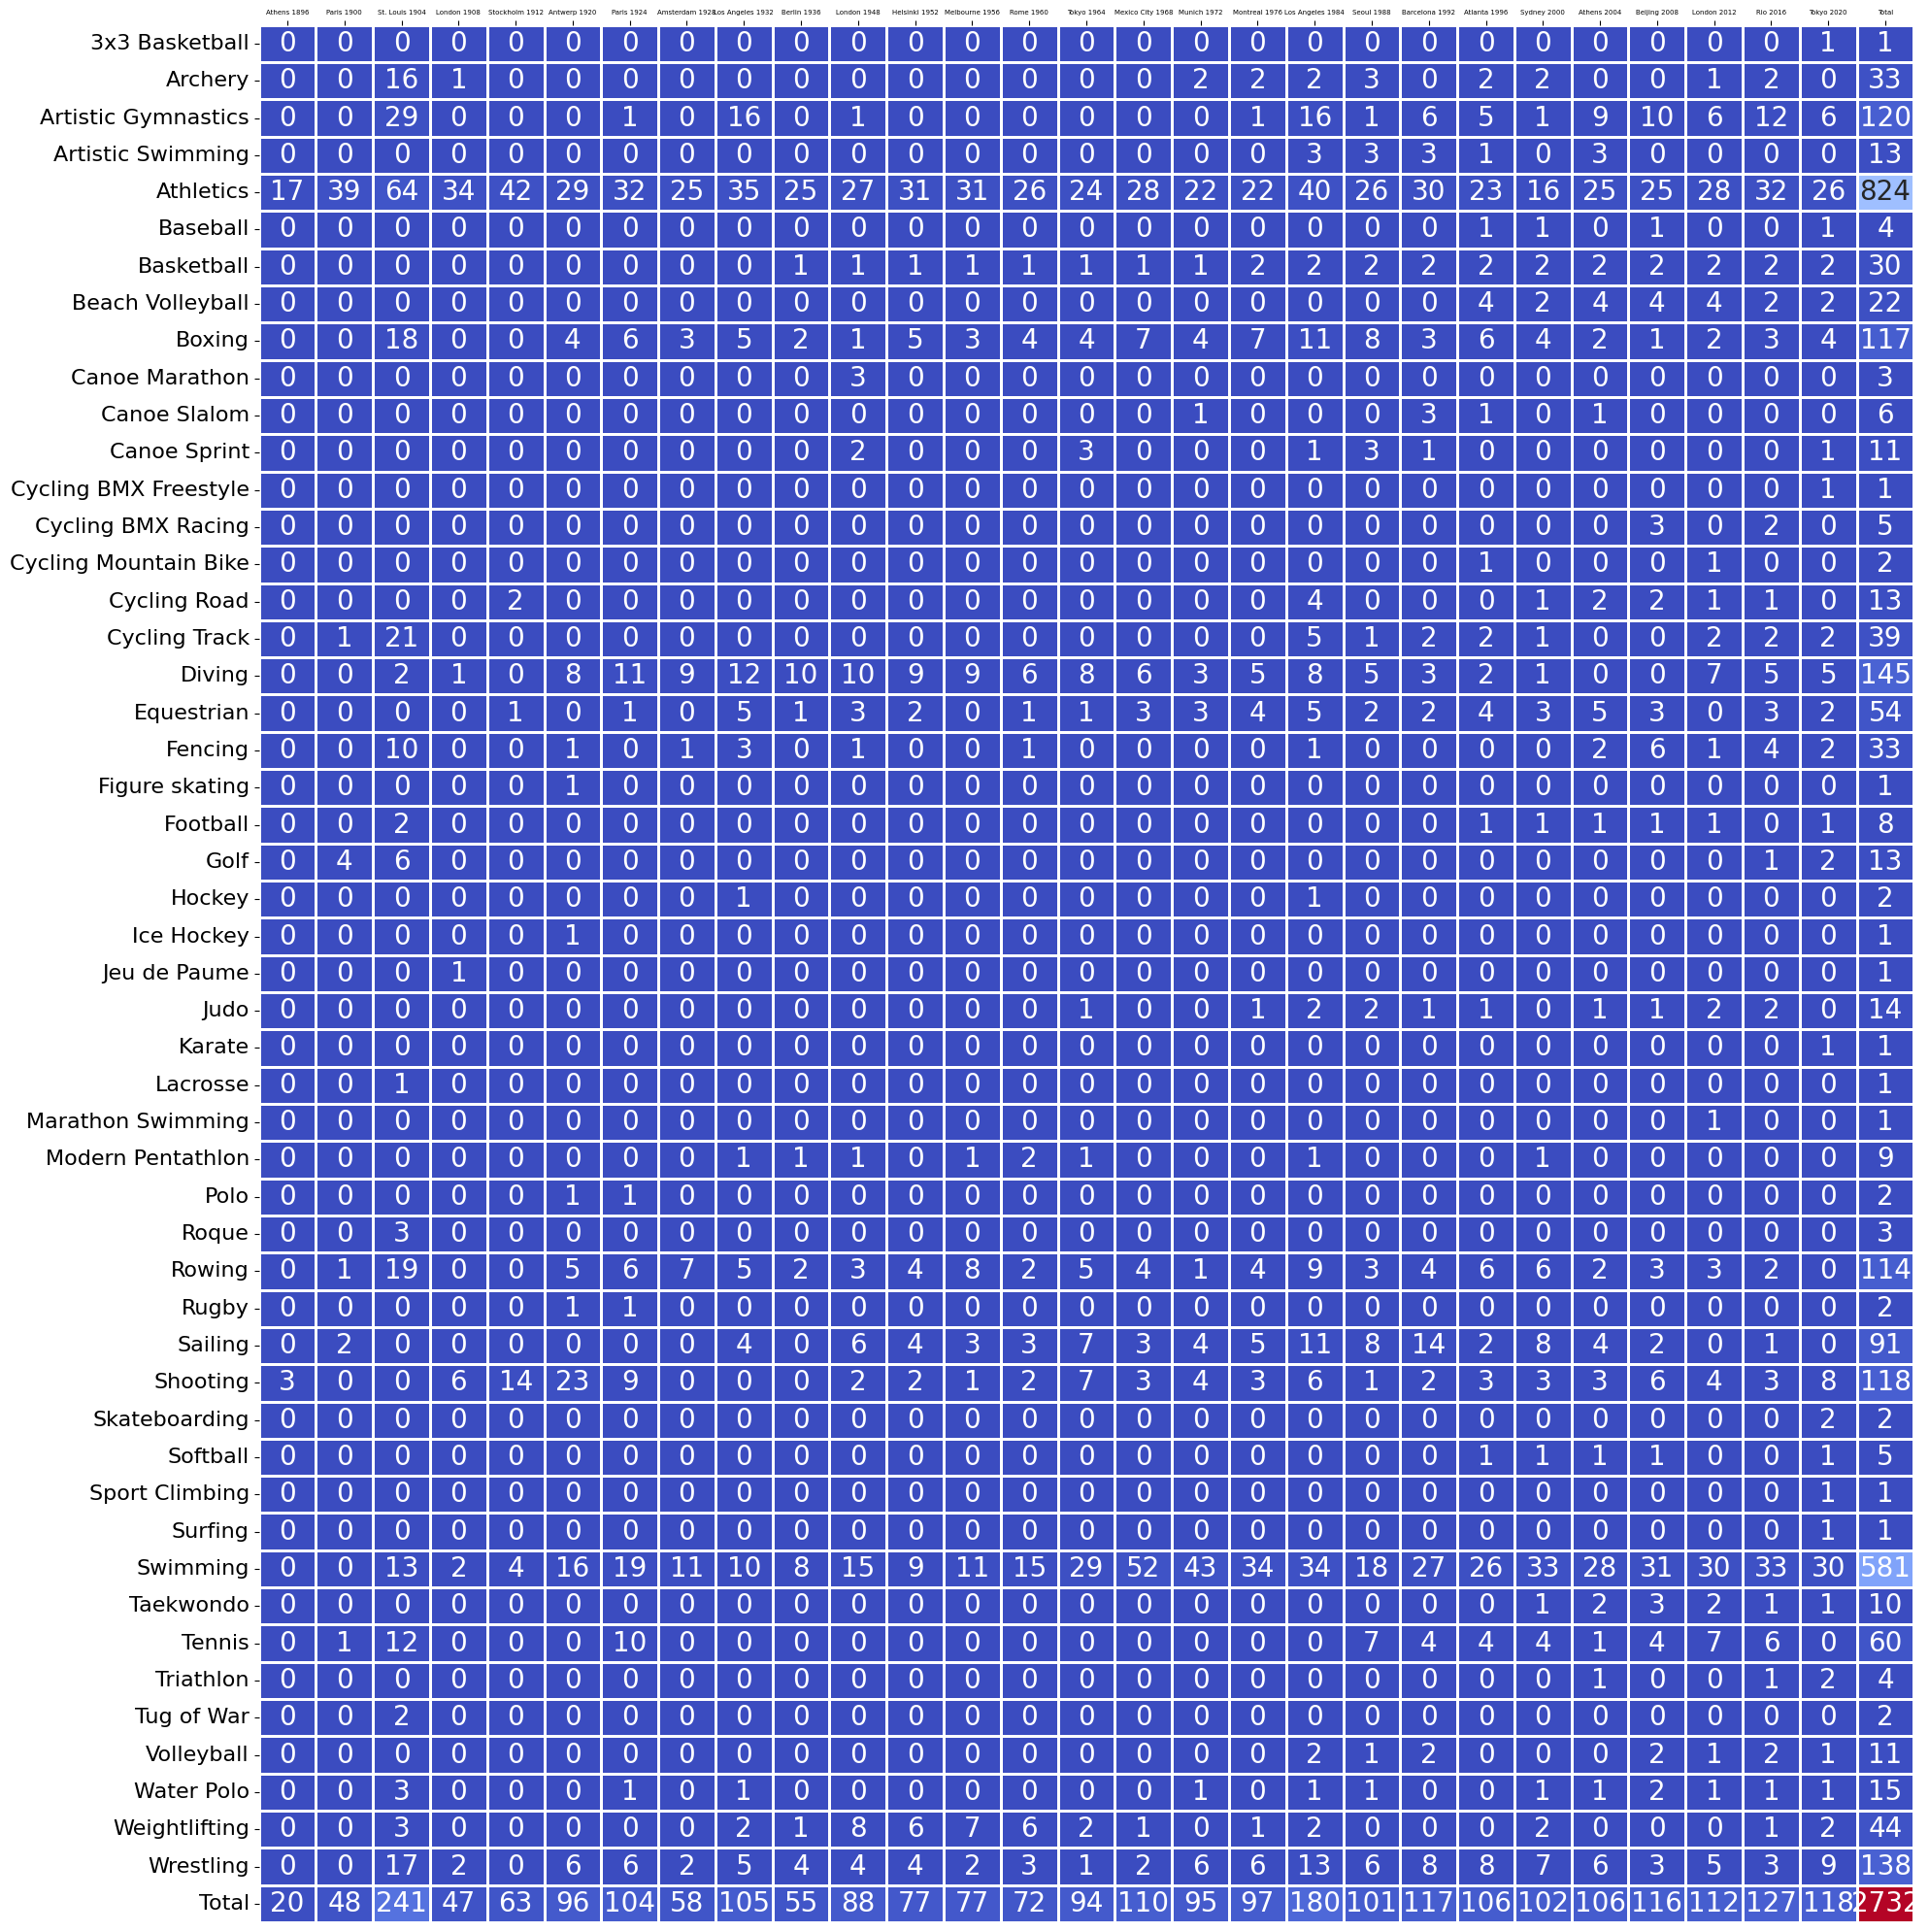

In [108]:
country_medal_usa = get_country_medal(data_summer, 'USA')
plot_country_medal(country_medal_usa)

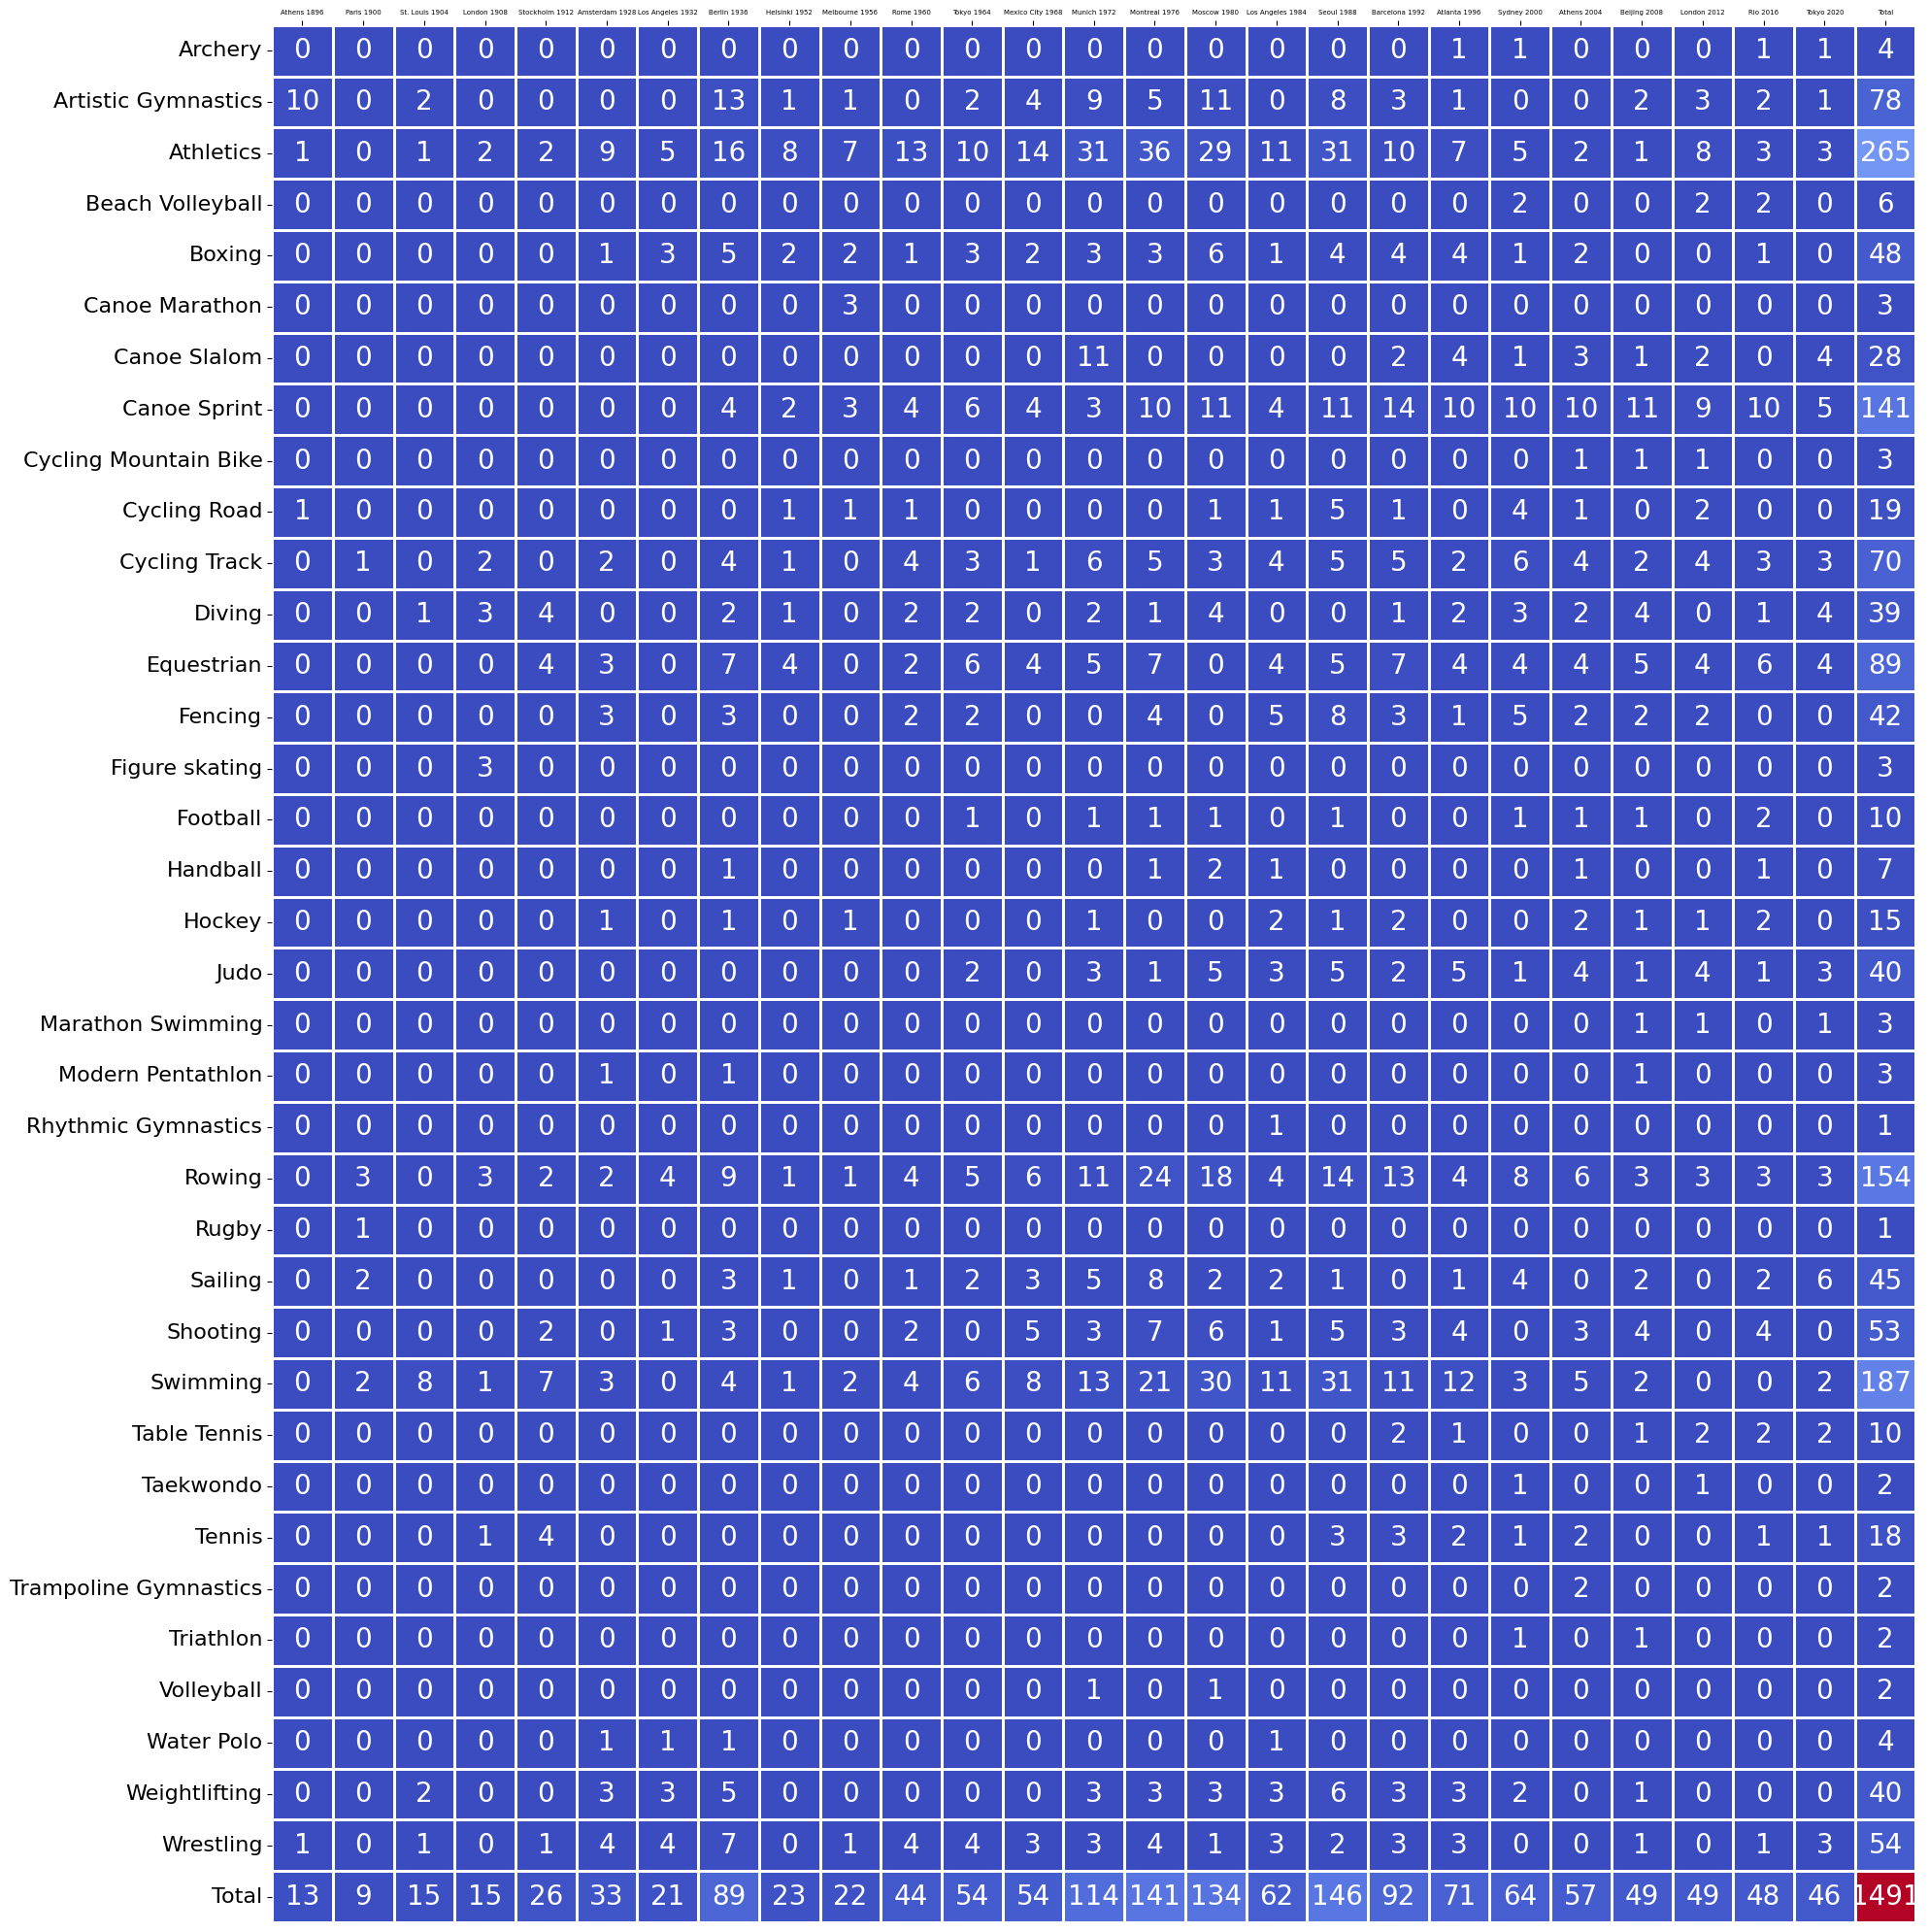

In [109]:
country_medal_usa = get_country_medal(data_summer, 'Germany')
plot_country_medal(country_medal_usa)

In [110]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Olympics Medal Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()


24/05/30 15:01:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:01:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [31]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Charger les données
data_medal = spark.read.csv('/kaggle/working/data_medal', header=True, inferSchema=True)

# Remplacer les valeurs nulles par une valeur spécifique ou supprimer les lignes avec des nulls
data_medal = data_medal.na.fill('Unknown')

# Définir les colonnes catégorielles
categorical_columns = ['discipline_title', 'event_title', 'event_gender', 'medal_type', 
                       'participant_type', 'participant_title', 'country_name', 
                       'country_code', 'country_3_letter_code', 'game_location', 
                       'game_name', 'game_season']

# Encodage des colonnes catégorielles et gestion des valeurs NULL
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="skip") for column in categorical_columns]

# Assembler les fonctionnalités en un seul vecteur
assembler = VectorAssembler(
    inputCols=[column+"_index" for column in categorical_columns if column != 'medal_type'],
    outputCol="features"
)

# Normalisation des fonctionnalités
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Créer le pipeline de transformations
pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Ajuster et transformer les données
data_preprocessed = pipeline.fit(data_medal).transform(data_medal)

# Sélectionner les fonctionnalités et l'étiquette
data_preprocessed = data_preprocessed.withColumn("label", col("medal_type_index")).select("scaledFeatures", "label")


24/05/30 12:47:10 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 12:47:10 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 12:47:10 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [111]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialiser SparkSession
spark = SparkSession.builder \
    .appName("Medal Prediction MLP") \
    .getOrCreate()

# Charger les données depuis votre source (remplacez path_to_data par le chemin de votre fichier)
df = data_medal

# Supprimer les colonnes inutiles
df = df.drop('athlete_url', 'country_code', 'country_3_letter_code')

# Encoder la variable catégorielle 'medal_type'
indexer = StringIndexer(inputCol="medal_type", outputCol="label")
indexed_df = indexer.fit(df).transform(df)

# Encoder les autres variables catégorielles
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") for column in ['discipline_title', 'event_title', 'event_gender', 'participant_type', 'athlete_full_name', 'country_name', 'game_location', 'game_name', 'game_season', 'game_year']]
pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(indexed_df).transform(indexed_df)

# Assembler les features
feature_columns = ['discipline_title_index', 'event_title_index', 'event_gender_index', 'participant_type_index', 'athlete_full_name_index', 'country_name_index', 'game_location_index', 'game_name_index', 'game_season_index', 'game_year_index']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Diviser les données en ensembles d'entraînement et de test
(trainingData, testData) = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Définir les couches du modèle MLP
layers = [len(feature_columns), 100, 50, 3]  # Nombre de caractéristiques en entrée, 100 neurones dans la première couche cachée, 50 neurones dans la deuxième couche cachée, 3 classes de sortie (GOLD, SILVER, BRONZE)

# Créer le modèle MLP
mlp = MultilayerPerceptronClassifier(layers=layers, seed=42, labelCol="label", featuresCol="features")

# Créer un pipeline
pipeline = Pipeline(stages=[mlp])

# Entraîner le modèle
model = pipeline.fit(trainingData)

# Évaluer le modèle sur l'ensemble de test
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Prédictions pour une nouvelle année (par exemple, 2024)
# Vous devez également avoir des données pour cette année-là
# Remplacez X_new par les données de cette nouvelle année
# predictions_2024 = model.transform(X_new)
# predictions_2024.select("prediction").show()

# Fermer la session Spark
#spark.stop()


24/05/30 15:02:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/05/30 15:02:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:02:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:02:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:03:12 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
24/05/30 15:03:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future

Accuracy: 0.3793022711308827


In [112]:
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("PySpark Prediction Example") \
    .getOrCreate()
# Load the data for the year 2024 into a Spark DataFrame
# Replace "path_to_2024_data" with the path to your data for the year 2024
df_2024 = spark.read.csv("/kaggle/working/df_2022", header=True, inferSchema=True)

# Apply the same preprocessing steps as before
# Drop unnecessary columns
df_2024 = df_2024.drop('athlete_url', 'country_code', 'country_3_letter_code')

# Encode categorical variables
indexed_df_2024 = indexer.fit(df_2024).transform(df_2024)
indexed_df_2024 = pipeline.fit(indexed_df_2024).transform(indexed_df_2024)
assembled_df_2024 = assembler.transform(indexed_df_2024)

# Make predictions using the trained model
predictions_2024 = model.transform(assembled_df_2024)

# Show predictions
predictions_2024.select("prediction").show()

24/05/30 15:03:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/05/30 15:03:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:03:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:03:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


IllegalArgumentException: features does not exist. Available: discipline_title, event_title, event_gender, medal_type, participant_type, participant_title, athlete_full_name, country_name, game_location, game_name, game_season, game_year, label

In [116]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, StringIndexerModel, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Medal Prediction MLP") \
    .getOrCreate()

# Step 2: Load and Preprocess Training Data
# Load the data
df = data_medal

# Drop unnecessary columns
df = df.drop('athlete_url', 'athlete_full_name', 'country_code', 'country_3_letter_code')

# Encode categorical variables
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") 
            for column in ['discipline_title', 'event_title', 'event_gender', 'participant_type', 
                           'country_name', 'game_location', 'game_name', 'game_season', 'game_year']]
pipeline_indexers = Pipeline(stages=indexers)
df_indexed = pipeline_indexers.fit(df).transform(df)

# Assemble features
feature_columns = ['discipline_title_index', 'event_title_index', 'event_gender_index', 
                   'participant_type_index', 'country_name_index', 'game_location_index', 'game_name_index', 
                   'game_season_index', 'game_year_index']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df_indexed)

# Encode 'medal_type' as label
label_indexer = StringIndexer(inputCol="medal_type", outputCol="label")
df_final = label_indexer.fit(df_assembled).transform(df_assembled)

# Split the data
(trainingData, testData) = df_final.randomSplit([0.8, 0.2], seed=42)

# Step 3: Train the MLP Model
layers = [len(feature_columns), 100, 50, 3]  # Number of features, hidden layers, and output classes
mlp = MultilayerPerceptronClassifier(layers=layers, seed=42, labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[mlp])
model = pipeline.fit(trainingData)

# Evaluate the model
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Step 4: Save the Model and Preprocessing Pipeline Components
model.write().overwrite().save("/kaggle/working/saved_model")
for i, indexer in enumerate(indexers):
    indexer_model = indexer.fit(df)
    indexer_model.write().overwrite().save(f"/kaggle/working/saved_indexer_{i}")
assembler.write().overwrite().save("/kaggle/working/saved_assembler")
label_indexer.write().overwrite().save("/kaggle/working/saved_label_indexer")

# Step 5: Load the Model and Preprocessing Pipeline for Predictions
model = PipelineModel.load("/kaggle/working/saved_model")
indexers_loaded = [StringIndexerModel.load(f"/kaggle/working/saved_indexer_{i}") for i in range(len(indexers))]
assembler = VectorAssembler.load("/kaggle/working/saved_assembler")
# Note: label_indexer is not needed for transforming the test data

# Step 6: Predict for 2024 Data
# Load the data for the year 2024
df_2024 = spark.read.csv("/kaggle/working/df_2022", header=True, inferSchema=True)

# Drop unnecessary columns
df_2024 = df_2024.drop('athlete_url', 'athlete_full_name', 'country_code', 'country_3_letter_code', 'medal_type')

# Apply the same preprocessing steps
for indexer in indexers_loaded:
    df_2024 = indexer.transform(df_2024)
df_2024_assembled = assembler.transform(df_2024)

# Make predictions using the trained model
predictions_2024 = model.transform(df_2024_assembled)

# Show predictions
predictions_2024.select("prediction").show()


24/05/30 15:20:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:03 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:33 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

Accuracy: 0.3624443924139546


24/05/30 15:20:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/30 15:20:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows

